## Customer Service Feature Engineering

In this section, we processed the raw `customer_service` dataset to create numeric features per customer suitable for churn modeling. The goal is to capture customer interactions, dissatisfaction, and service resolution.

### Original Columns
- `customer_id` – Unique identifier for each customer
- `interaction_id` – Unique identifier for each interaction
- `interaction_date` – Date of the interaction
- `interaction_type` – Type of interaction: Inquiry, Feedback, Complaint
- `resolution_status` – Status of the interaction: Resolved or Unresolved

### Feature Engineering Steps

1. **Aggregate interaction counts per customer**
   - `no_complaints` – Total number of complaints
   - `no_feedbacks` – Total number of feedbacks
   - `no_inquiries` – Total number of inquiries
   - `no_resolved` – Total number of resolved interactions
   - `no_unresolved` – Total number of unresolved interactions
   - `no_interactions` – Total number of interactions

2. **Compute recency**
   - `last_interaction_date` – Most recent interaction date
   - `first_interaction_date` – Earliest interaction date
   - `recency` – Number of days since the last interaction

3. **Create derived rates for predictive modeling**
   - `complaint_rate = no_complaints / no_interactions`
   - `resolution_rate = no_resolved / no_interactions`

### Notes
- Boolean flags (e.g., unresolved feedback) were considered but aggregated numeric features are preferred for churn modeling.
- Features like `inquiry_rate` were omitted because they are less predictive of churn.
- The final dataset contains numeric, aggregated, and recency-based features for each customer, ready to be merged with transaction and other datasets for modeling.


In [69]:
from itertools import groupby

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from narwhals.stable.v1 import Datetime
from sqlalchemy.dialects.mssql.information_schema import columns
from sqlalchemy.sql.functions import current_timestamp

In [70]:
customer_service = pd.read_csv('/Users/mac/PycharmProjects/Customer_Churn/Datasets/csv_files/crm_customer_service.csv')
customer_service.head()

,customer_id,interaction_id,interaction_date,interaction_type,resolution_status
0,1,6363,2022-03-31,Inquiry,Resolved
1,2,3329,2022-03-17,Inquiry,Resolved
2,3,9976,2022-08-24,Inquiry,Resolved
3,4,7354,2022-11-18,Inquiry,Resolved
4,4,5393,2022-07-03,Inquiry,Unresolved


In [71]:
customer_service['interaction_date'] = pd.to_datetime(customer_service['interaction_date'])
customer_service.head(100)

,customer_id,interaction_id,interaction_date,interaction_type,resolution_status
0,1,6363,2022-03-31,Inquiry,Resolved
1,2,3329,2022-03-17,Inquiry,Resolved
2,3,9976,2022-08-24,Inquiry,Resolved
3,4,7354,2022-11-18,Inquiry,Resolved
4,4,5393,2022-07-03,Inquiry,Unresolved
...,...,...,...,...,...
95,96,5701,2022-01-26,Complaint,Unresolved
96,96,8412,2022-02-20,Complaint,Unresolved
97,97,5336,2022-04-16,Inquiry,Resolved
98,97,8734,2022-08-11,Complaint,Resolved


<Axes: xlabel='interaction_type', ylabel='count'>

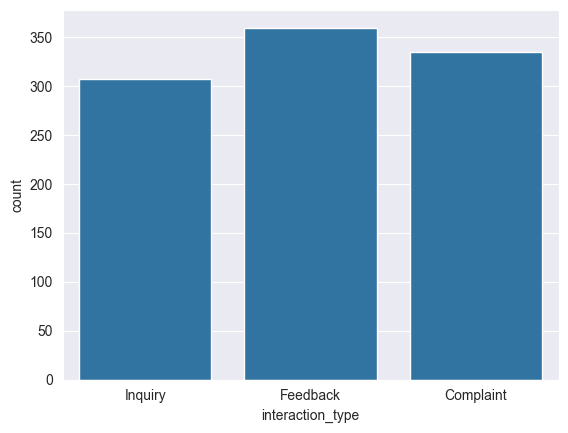

In [72]:
sns.countplot(data=customer_service,x='interaction_type')

In [73]:
customer_service_new = customer_service.groupby('customer_id', as_index=False).agg(
no_complaints = ('interaction_type', lambda x: (x == 'Complaint').sum()),
no_feedbacks = ('interaction_type',lambda x:(x == 'Feedback').sum()),
no_inquiry = ('interaction_type',lambda x:(x == 'Inquiry').sum()),
no_resolved = ('resolution_status',lambda x:(x == 'Resolved').sum()),
no_unresolved = ('resolution_status',lambda x:(x == 'Unresolved').sum()),
no_interactions = ('interaction_id','count'),
last_interaction_date = ('interaction_date','max'),
first_interaction_date = ('interaction_date','min'))

today = pd.Timestamp.today().normalize()
customer_service_new['recency'] = (today - customer_service_new['last_interaction_date']).dt.days
customer_service_new.head(10)



,customer_id,no_complaints,no_feedbacks,no_inquiry,no_resolved,no_unresolved,no_interactions,last_interaction_date,first_interaction_date,recency
0,1,0,0,1,1,0,1,2022-03-31,2022-03-31,1269
1,2,0,0,1,1,0,1,2022-03-17,2022-03-17,1283
2,3,0,0,1,1,0,1,2022-08-24,2022-08-24,1123
3,4,0,0,2,1,1,2,2022-11-18,2022-07-03,1037
4,6,0,1,0,1,0,1,2022-05-05,2022-05-05,1234
5,8,0,1,1,0,2,2,2022-09-13,2022-04-29,1103
6,9,0,0,1,1,0,1,2022-08-15,2022-08-15,1132
7,11,0,2,0,1,1,2,2022-10-28,2022-01-26,1058
8,12,0,1,1,1,1,2,2022-11-29,2022-01-12,1026
9,13,1,0,0,1,0,1,2022-07-27,2022-07-27,1151


In [74]:
customer_service_new.drop(['last_interaction_date','first_interaction_date'], axis=1, inplace=True)



In [75]:
customer_service_new.head()



,customer_id,no_complaints,no_feedbacks,no_inquiry,no_resolved,no_unresolved,no_interactions,recency
0,1,0,0,1,1,0,1,1269
1,2,0,0,1,1,0,1,1283
2,3,0,0,1,1,0,1,1123
3,4,0,0,2,1,1,2,1037
4,6,0,1,0,1,0,1,1234


In [76]:
customer_service_new['complaint_rate'] = customer_service_new['no_complaints']/customer_service_new['no_interactions']
customer_service_new['unresolution_rate'] = customer_service_new['no_unresolved']/customer_service_new['no_interactions']
customer_service_new['feedback_rate'] = customer_service_new['no_feedbacks']/customer_service_new['no_interactions']
customer_service_new.head(100)

,customer_id,no_complaints,no_feedbacks,no_inquiry,no_resolved,no_unresolved,no_interactions,recency,complaint_rate,unresolution_rate,feedback_rate
0,1,0,0,1,1,0,1,1269,0.0,0.0,0.0
1,2,0,0,1,1,0,1,1283,0.0,0.0,0.0
2,3,0,0,1,1,0,1,1123,0.0,0.0,0.0
3,4,0,0,2,1,1,2,1037,0.0,0.5,0.0
4,6,0,1,0,1,0,1,1234,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
95,139,0,1,1,1,1,2,1160,0.0,0.5,0.5
96,140,0,1,0,1,0,1,1242,0.0,0.0,1.0
97,141,2,0,0,2,0,2,1216,1.0,0.0,0.0
98,142,0,1,0,0,1,1,1296,0.0,1.0,1.0


<Axes: xlabel='position', ylabel='count'>

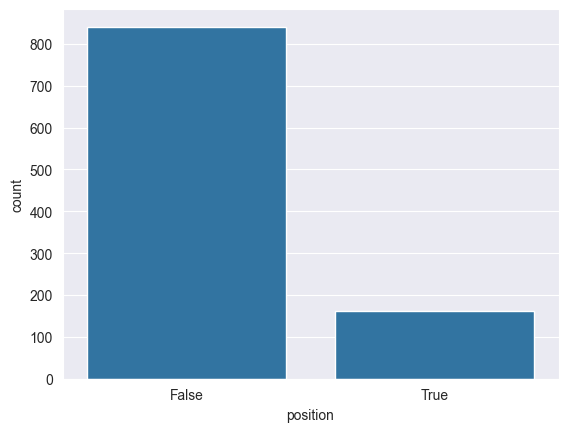

In [77]:
feedback_check = pd.DataFrame(
    columns=['position'],
    data=((customer_service['interaction_type'] == 'Feedback') &
          (customer_service['resolution_status'] == 'Unresolved'))
)

sns.countplot(data=feedback_check, x='position')


<Axes: xlabel='position', ylabel='count'>

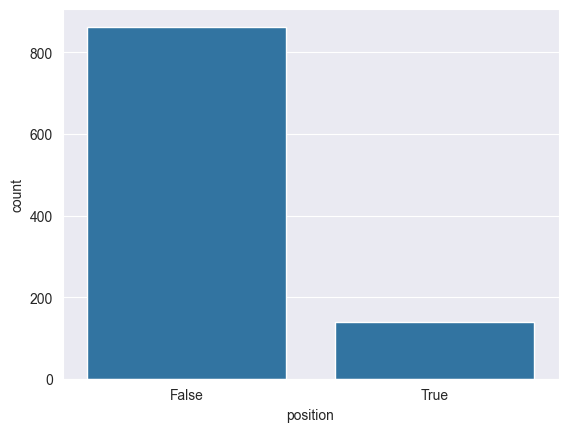

In [78]:
inquiry_check = pd.DataFrame(
    columns=['position'],
    data=((customer_service['interaction_type'] == 'Inquiry') &
          (customer_service['resolution_status'] == 'Unresolved'))
)

sns.countplot(data=inquiry_check, x='position')



<Axes: xlabel='position', ylabel='count'>

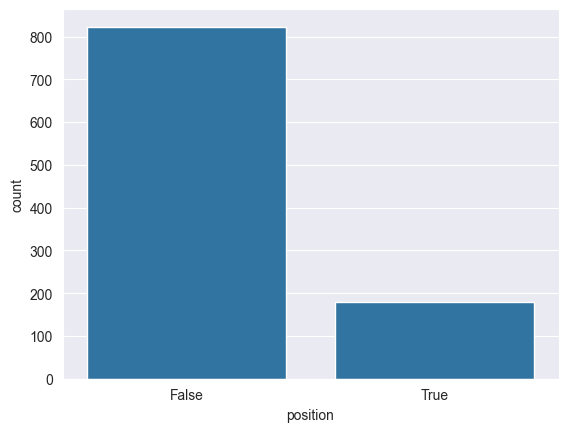

In [79]:
complaint_check = pd.DataFrame(
    columns=['position'],
    data=((customer_service['interaction_type'] == 'Complaint') &
          (customer_service['resolution_status'] == 'Unresolved'))
)

sns.countplot(data=complaint_check, x='position')

In [80]:
customer_service_new.to_csv('customer_service', index=False)